# Data-driven surrogate model for maximum displacement of oscillating mass

Information:
* Author: Dr.-Ing. Mauricio Fernández
* Last edited: 2021-12-05

Table of contents
* [Illustration of dynamic system](#Illustration-of-dynamic-system)
* [Data-driven model](#Data-driven-model)
    * [Design of experiments](#Design-of-experiments)
    * [Data generation](#Data-generation)
    * [Model generation and calibration](#Model-generation-and-calibration)
    * [Predictions](#Predicitions)

Required modules

In [1]:
import numpy as np
import sys
sys.path.append('../files/modules/')
import single_mass as sm

## Illustration of dynamic system

We consider the following ODE
$$
    m \ddot{u}(t) + d \dot{u}(t) + c u(t) = f_a \sin(f_f t)
$$
corresponding to a single mass point with mass $m$, damping coefficient $d$ and stiffness $c$ under the excitation of the external force $f(t) = f_a \sin(f_f t)$ with amplitude $f_a$ and frequency $f_f$. The displacement of the mass point is denoted by the function $u(t)$. 

The 2nd-order linear inhomogeneous ODE can be transformed into a vector-valued first-order ODE system with $x(t) = [x_1(t), x_2(t)]^T = [u(t), \dot{u}(t)]^T$, i.e., 
$$
    \dot{x}(t) 
    = 
    \left[
    \begin{matrix}
    x_2(t) \\
    \frac{1}{m}(f_a \sin(f_f t) - d x_2(t) - c x_1(t))
    \end{matrix} 
    \right]
$$
which then can be solved with given initial conditions $x(0)$.

Depending on the explicit values of the parameters $m, d, c, f_a, f_f$, the system shows different behavior.


No damping ($d=0$).

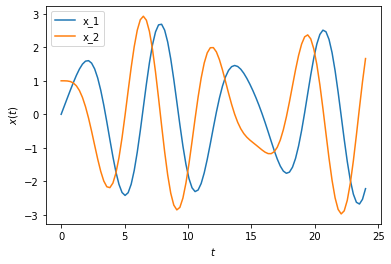

In [2]:
t_a, x_a = sm.solve_parametric(m=1, d=0, c=2, x_0=[0, 1], f_a=2, f_f=1, t_end=24)
sm.plot_sol(t_a, x_a)

With damping ($d>0$) the oscillations of the mass displacement ($x_1(t) = u(t)$) are reduced.

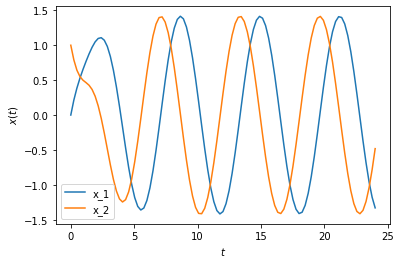

In [3]:
t_a, x_a = sm.solve_parametric(m=1, d=1, c=2, x_0=[0, 1], f_a=2, f_f=1, t_end=24)
sm.plot_sol(t_a, x_a)

Assume that the dynamic system given above represents the oscillatory behavior of a critical point in a larger system, e.g., a critical position in a building loaded with oscillating wind or the middle point of a beam under cyclic loading. For structure-safety reasons, it may be necessary to avoid large deformations/displacements in a corresponding real-world scenario, such that knowledge of maximum occurring oscillations would be of great value. In this example, a surrogate model predicting the maximum displacement and ocurring time point is built. Such a surrogate model could be used, for instance, building optimization tasks or in digital twins for future designing of engineering structures. 

## Data-driven model

As a simple example, we will consider the variation of the parameter vector $p = [d, c, f_f]^T$ and keep $m=1$, $f_a=2$, $t_\mathrm{max} = 24$ and $x(0) = [0, 0]^T$ fixed. Our objective is to build a surrogate model $s(p)$, which predicts for $p$ the maximum displacement (in terms of its absolute value) $u(t) = x_1(t)$ in $t \in [0, t_\mathrm{max}]$ and the time point of the maximum. The quantity of interest $q$ is then defined as $q = [q_1, q_2] = [t_\mathrm{max}, u_\mathrm{max}]$. The surrogate model then maps for the space of parameters $P \subset \mathbb{R}^3$ into the space of the quantity of interest $Q \subset \mathbb{R}^2$, i.e., $s(p) = q$.

### Design of experiments

We sample the input space $P$ (space of $p$) with the most simple discretization possible (uniformly).

In [4]:
p_a = sm.design_of_experiments(
    d_range=[0, 2],
    c_range=[0.1, 1.5], 
    f_f_range=[0.1, 1.5], 
    n = 5
)
print(p_a.shape)
print(p_a[:6])

(125, 3)
[[0.   0.1  0.1 ]
 [0.   0.1  0.45]
 [0.   0.1  0.8 ]
 [0.   0.1  1.15]
 [0.   0.1  1.5 ]
 [0.   0.45 0.1 ]]


### Objective data generation

The routine `generate_objective_data()` computes the solution of the dynamic system for every parameter vector in the array `p_a` and determines the corresponding maximum time and displacement.

In [5]:
q_a = sm.generate_objective_data(p_a)
print(q_a.shape)
print(q_a[:6])

(125, 2)
[[15.12       29.19439643]
 [24.         45.94082985]
 [ 5.52       12.76917346]
 [ 4.32        7.40811234]
 [24.          5.18159669]
 [16.32        5.2137668 ]]


### Model calibration

Generate a model (based on `tensorflow`). The model is compiled to minimize the MSE (mean squared error) in the output space (for $q \in Q$).

In [6]:
model = sm.generate_tf_model(n_hl=[16]*3, l_r=0.005)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


Train the model with the generated data and the method `.fit()`.

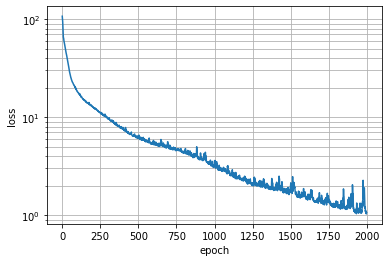

In [7]:
h = model.fit(p_a, q_a, epochs=2000, verbose=0)
sm.plot_train_history(h)

### Predictions

Surrogate prediction after calibration for a data point of the training set.

Parameters:
	[0.   0.45 1.15]


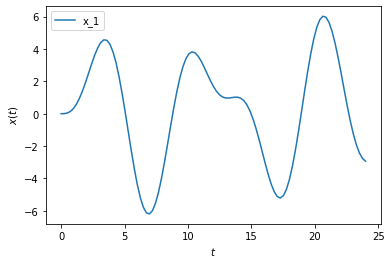

Time: 6.96
Displacement: -6.19247465971059
Surrogate prediction:
	[ 7.0078144 -6.5604906]


In [8]:
i = 8
p = p_a[i]
print(f"Parameters:\n\t{p}")
q = sm.compute_objective(p, plot=True, info=True)
q_s = model(np.array([p])).numpy()[0]
print(f"Surrogate prediction:\n\t{q_s}")

It should be noted, that the surrogate model computes predictions for the maximum displacement without any gradient investigation, case examination and boundary checkups as in normal extremal point computations. The ANN approximates the intrinsic relation between input and output through the provided training data. 

Test point NOT included in the training dataset.

Parameters:
	[0.4 1.2 0.2]


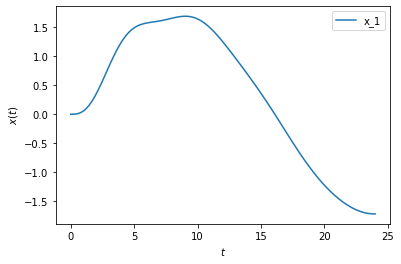

Time: 24.0
Displacement: -1.720617689047663
Surrogate prediction:
	[12.279592   1.6547165]


In [9]:
p = np.array([0.4, 1.2, 0.2])
print(f"Parameters:\n\t{p}")
q = sm.compute_objective(p, plot=True, info=True)
q_s = model(np.array([p])).numpy()[0]
print(f"Surrogate prediction:\n\t{q_s}")

Find closes behavior.

Parameters:
	[0.5  1.15 0.1 ]


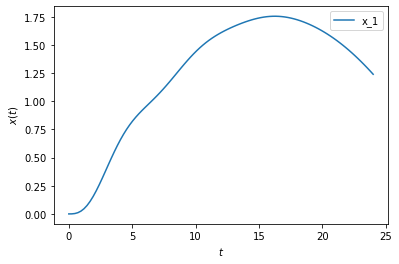

Time: 16.32
Displacement: 1.7545459060860575
Surrogate prediction:
	[15.873222   1.9404798]


In [10]:
i_closest = sm.i_closest(np.array([0.4, 1.2, 0.2]), p_a)
p = p_a[i_closest]
print(f"Parameters:\n\t{p}")
q = sm.compute_objective(p, plot=True, info=True)
q_s = model(np.array([p])).numpy()[0]
print(f"Surrogate prediction:\n\t{q_s}")